In [14]:
import numpy as np
import pandas as pd
import os
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind

In [15]:
#read all loc/spectrum loc data taken at 5 locations: campanile, sudardja dai hall 1st and 7th floors, etcheverry basement and radiation detection box

url = "https://raw.githubusercontent.com/seansbeyer/E11_rep/main"
data_campanile = pd.read_csv(f"{url}/(Campanile)%20Loc1_session1_group1_2025-04-30_16-01-35.csv")
data_campanile_spectrum = pd.read_csv(f"{url}/(Campanile)%20Spectrum_Loc1_session1_group1_2025-04-30_16-01-35.csv")
data_sudardja_1 = pd.read_csv(f"{url}/(SD%20Hall%201st)%20Loc1_session1_group1_2025-04-30_15-40-02.csv")
data_sudardja_1_spectrum = pd.read_csv(f"{url}/(SD%20Hall%201st)%20Spectrum_Loc1_session1_group1_2025-04-30_15-40-02.csv")
data_sudartja_7_ = pd.read_csv(f"{url}/(SD%20Hall%207th)%20Loc1_session1_group1_2025-04-30_15-27-44.csv")
data_sudartja_7_spectrum = pd.read_csv(f"{url}/(SD%20Hall%207th)%20Spectrum_Loc1_session1_group1_2025-04-30_15-27-44.csv")
data_etch_1140 = pd.read_csv(f"{url}/(Etch%201140)%20Loc1_session1_group1_2025-04-23_16-39-24.csv")
data_etch_1140_spectrum = pd.read_csv(f"{url}/(Etch%201140)%20Spectrum_Loc1_session1_group1_2025-04-23_16-39-24.csv")
data_etch_box = pd.read_csv(f"{url}/(Etch%20Box)%20Loc1_session1_group1_2025-04-23_16-45-33.csv")
data_etch_box_spectrum = pd.read_csv(f"{url}/(Etch%20Box)%20Spectrum_Loc1_session1_group1_2025-04-23_16-45-33.csv")

In [16]:
#we want only the first 300 rows (10 minutes) to be used
data_campanile = data_campanile.head(300)
data_campanile_spectrum = data_campanile_spectrum.head(300)
data_sudardja_1 = data_sudardja_1.head(300)
data_sudardja_1_spectrum = data_sudardja_1_spectrum.head(300)
data_sudartja_7= data_sudartja_7_.head(300)
data_sudartja_7_spectrum = data_sudartja_7_spectrum.head(300)
data_etch_1140 = data_etch_1140.head(300)
data_etch_1140_spectrum = data_etch_1140_spectrum.head(300)
data_etch_box = data_etch_box.head(300)
data_etch_box_spectrum = data_etch_box_spectrum.head(300)

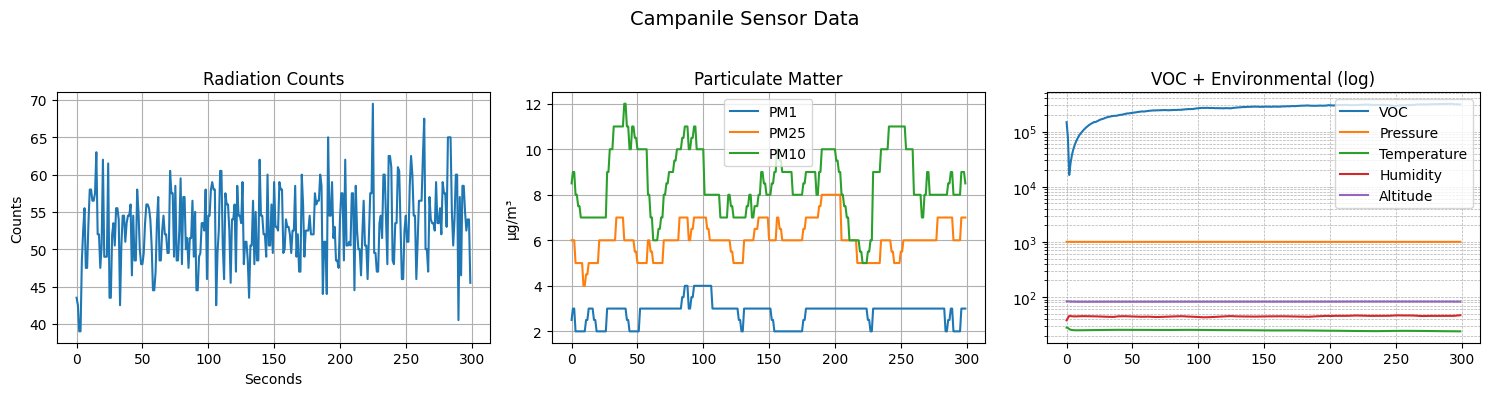

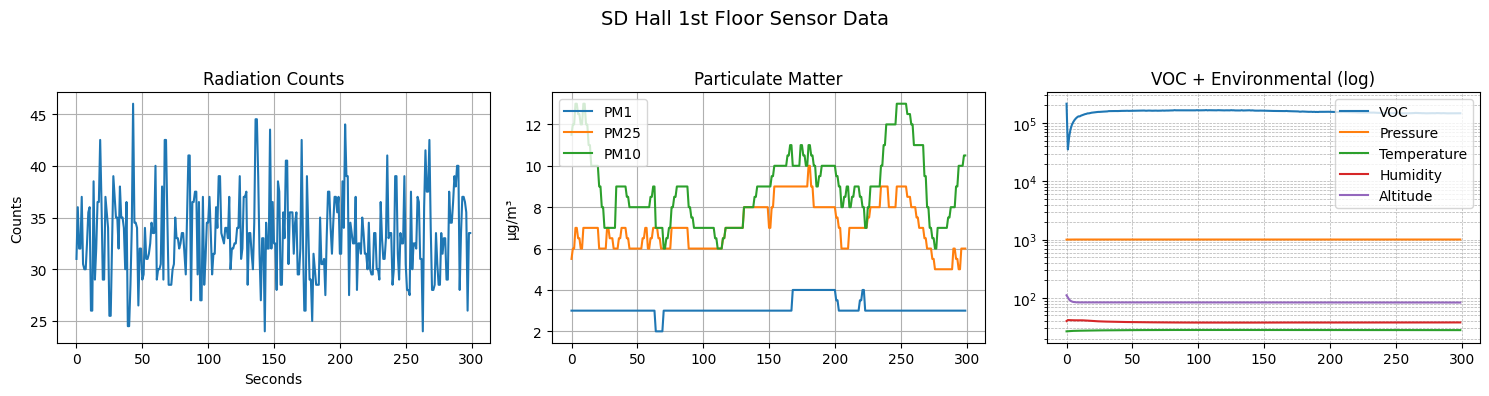

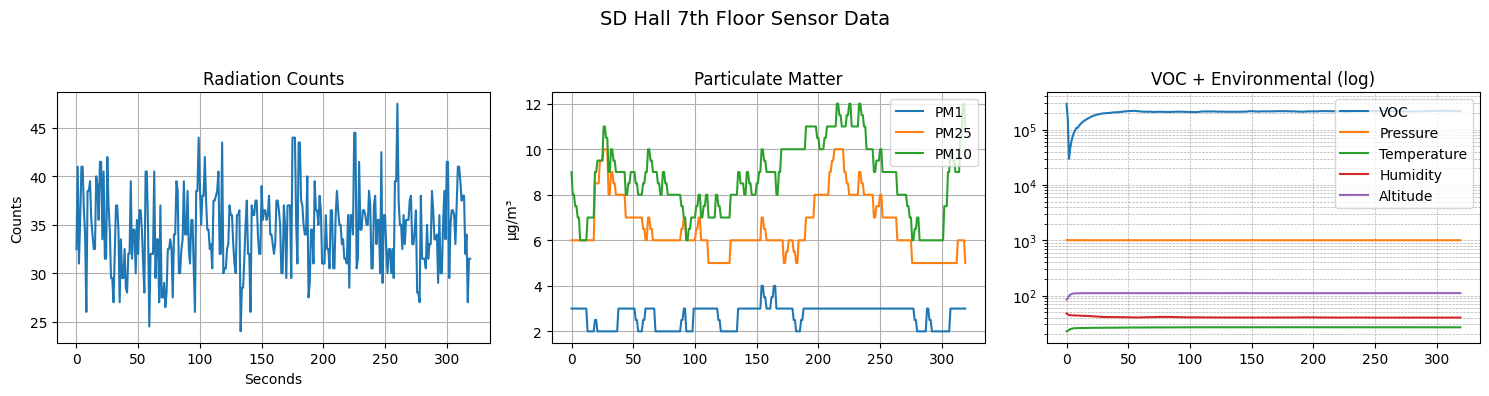

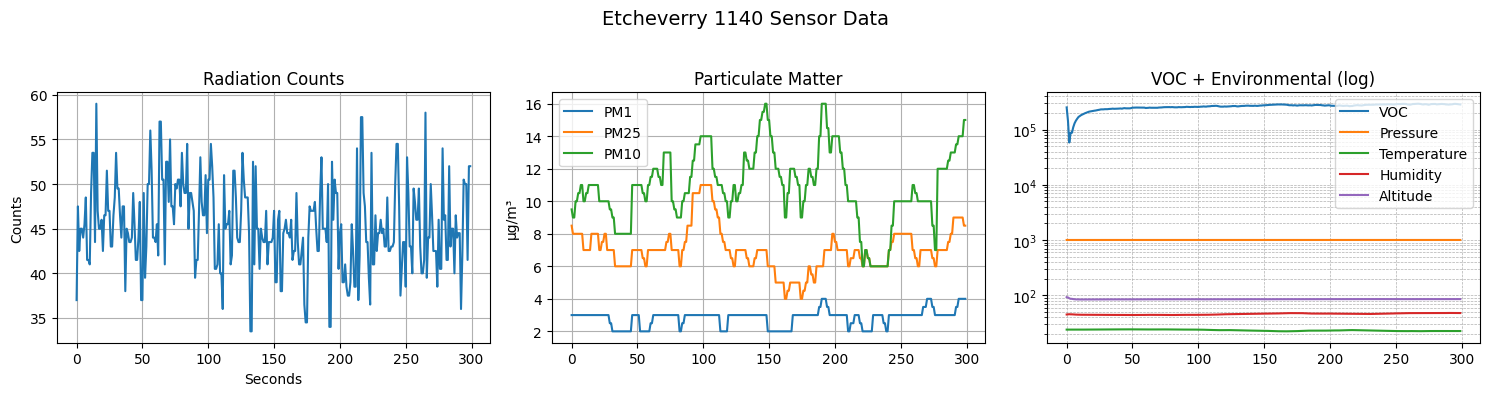

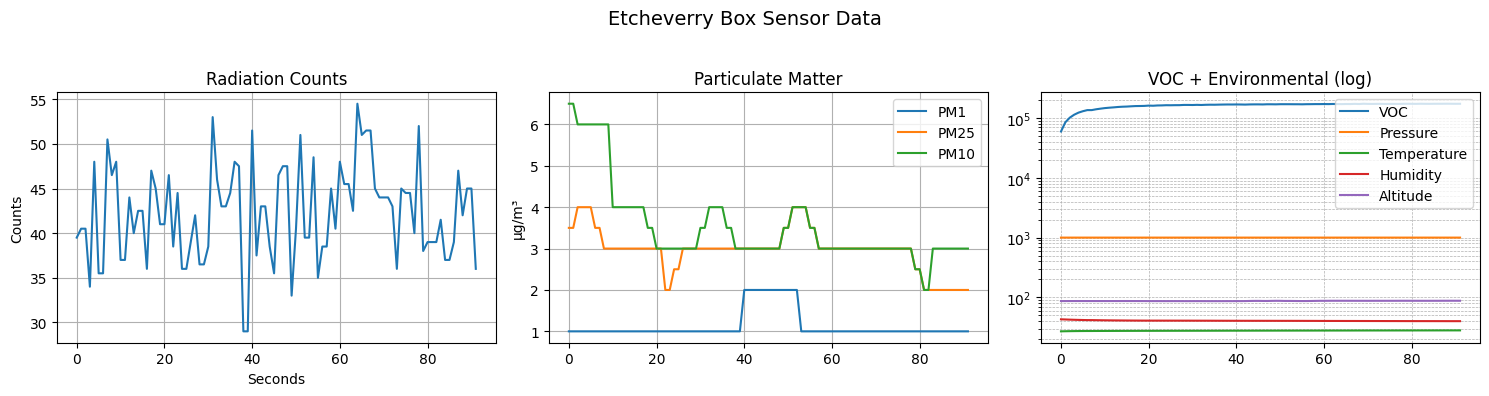

In [17]:
location_datasets = {
    "Campanile": data_campanile,
    "SD Hall 1st Floor": data_sudardja_1,
    "SD Hall 7th Floor": data_sudartja_7_,
    "Etcheverry 1140": data_etch_1140,
    "Etcheverry Box": data_etch_box
}

for location, df in location_datasets.items():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{location} Sensor Data", fontsize=14)

    #counts
    axes[0].plot(df["counts"], label="Counts")
    axes[0].set_title("Radiation Counts")
    axes[0].set_ylabel("Counts")
    axes[0].set_xlabel("Seconds")
    axes[0].grid(True)

    #PM
    pm_vars = ["PM1", "PM25", "PM10"]
    has_pm = any(var in df.columns for var in pm_vars)
    for var in pm_vars:
        if var in df.columns:
          axes[1].plot(df[var], label=var)
    axes[1].set_title("Particulate Matter")
    axes[1].set_ylabel("µg/m³")
    axes[0].set_xlabel("Seconds")
    axes[1].legend()
    axes[1].grid(True)

    #Environment (logarithmic)
    env_vars = ["VOC", "Pressure", "Temperature", "Humidity", "Altitude"]
    has_env = any(var in df.columns for var in env_vars)
    for var in env_vars:
        if var in df.columns:
            axes[2].plot(df[var], label=var)
    axes[2].set_title("VOC + Environmental (log)")
    axes[2].set_yscale("log")
    axes[0].set_xlabel("Seconds")
    axes[2].legend()
    axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave room for title
    plt.show()

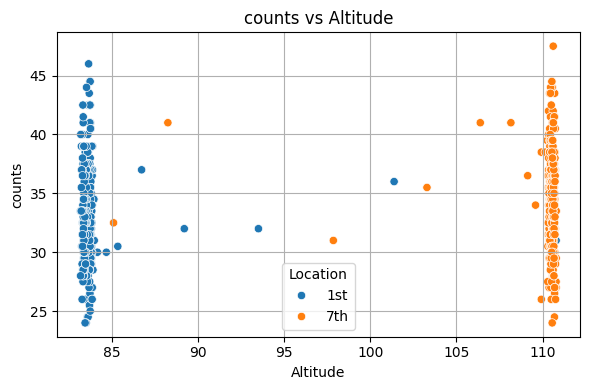

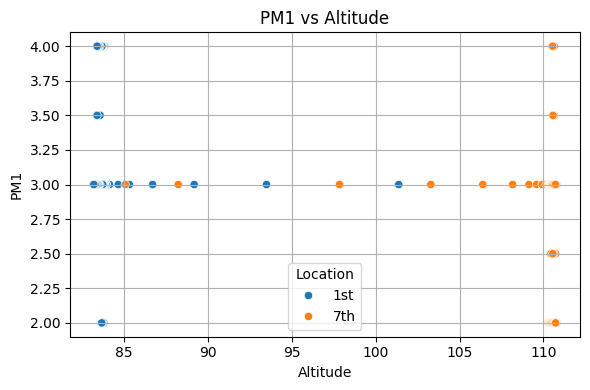

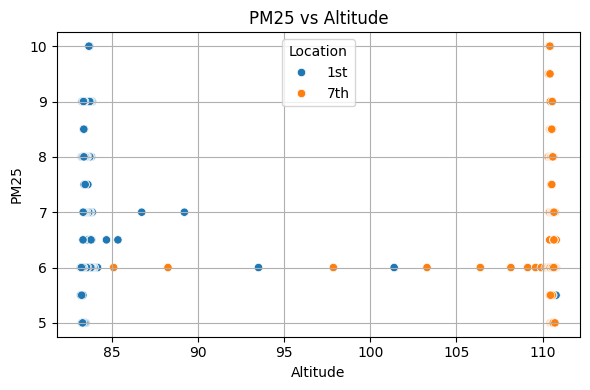

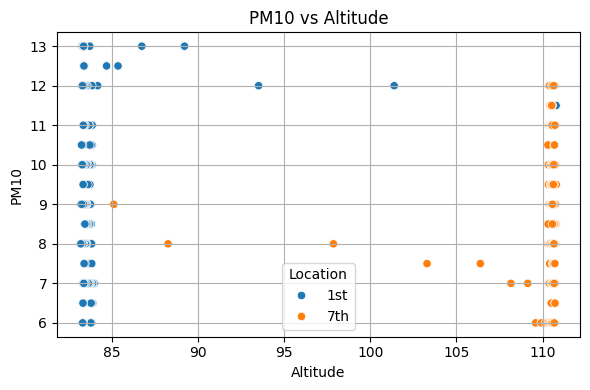

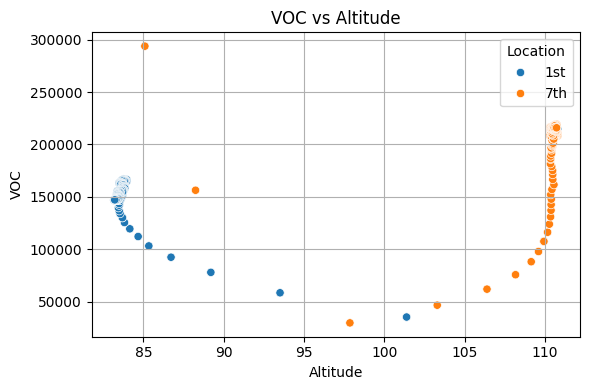

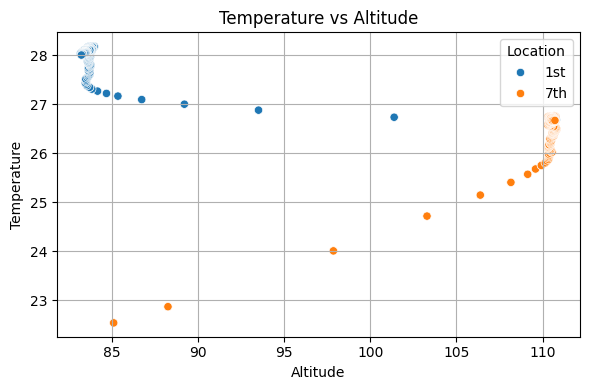

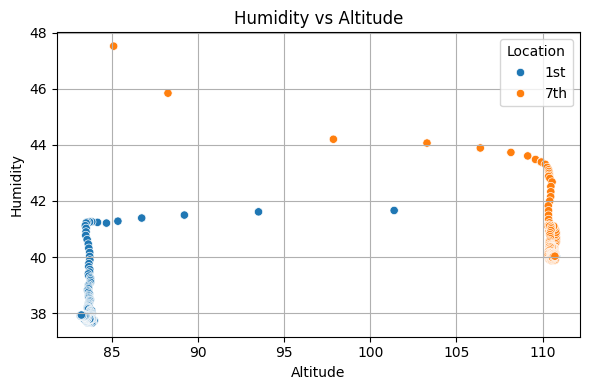

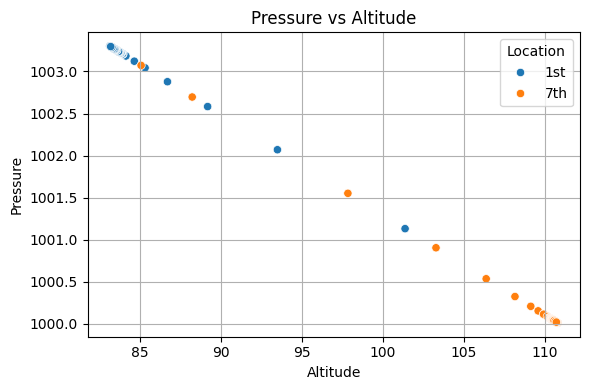

Linear Regression: Altitude → Sensor Value

counts      : R² = 0.021, slope = 0.045, intercept = 29.501
PM1         : R² = 0.188, slope = -0.015, intercept = 4.388
PM25        : R² = 0.043, slope = -0.020, intercept = 8.734
PM10        : R² = 0.003, slope = -0.007, intercept = 9.540
VOC         : R² = 0.594, slope = 1908.092, intercept = -4279.394
Temperature : R² = 0.755, slope = -0.053, intercept = 32.387
Humidity    : R² = 0.564, slope = 0.082, intercept = 31.358
Pressure    : R² = 1.000, slope = -0.119, intercept = 1013.197


In [18]:
#### TEST 1: DOES ALTITUDE CORRELATE WITH OTHER PARAMETERS

shared_cols = list(set(data_sudardja_1.columns) & set(data_sudartja_7_.columns))
df1 = data_sudardja_1[shared_cols].copy()
df1["Location"] = "1st"
df2 = data_sudartja_7_[shared_cols].copy()
df2["Location"] = "7th"
combined = pd.concat([df1, df2])

sensor_vars = ["counts", "PM1", "PM25", "PM10", "VOC", "Temperature", "Humidity", "Pressure"]

for var in sensor_vars:
    if var in combined.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=combined, x="Altitude", y=var, hue="Location")
        plt.title(f"{var} vs Altitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print("Linear Regression: Altitude → Sensor Value\n")
for var in sensor_vars:
    if var in combined.columns:
        valid = combined[["Altitude", var]].dropna()
        X = valid["Altitude"].values.reshape(-1, 1)
        y = valid[var].values
        model = LinearRegression().fit(X, y)
        r2 = model.score(X, y)
        slope = model.coef_[0]
        intercept = model.intercept_
        print(f"{var:<12}: R² = {r2:.3f}, slope = {slope:.3f}, intercept = {intercept:.3f}")

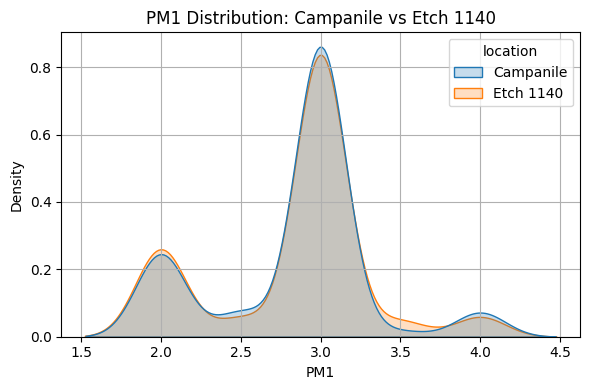

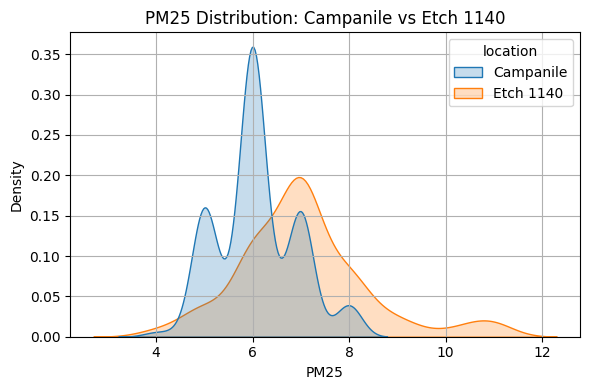

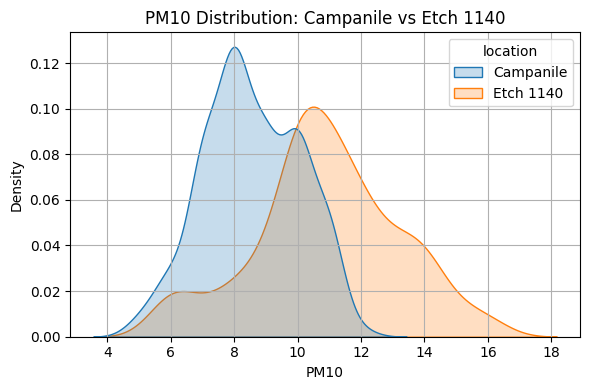

T-Test Results (Campanile vs Etch 1140):

PM1  : t = 0.124, p = 0.90165
PM25 : t = -10.479, p = 0.00000
PM10 : t = -14.908, p = 0.00000

Random Forest Classifier Accuracy (PM → Location): 0.844


In [19]:
#TEST 2: Data analysis on PM levels on a purposely high and purposely low PM area. Can we predict which an indoor area vs an outdoor area based solely on PM levels?

campanile_pm = data_campanile[["PM1", "PM25", "PM10"]].copy()
etch_pm = data_etch_1140[["PM1", "PM25", "PM10"]].copy()

campanile_pm["location"] = "Campanile"
etch_pm["location"] = "Etch 1140"

combined = pd.concat([campanile_pm, etch_pm], ignore_index=True)

for col in ["PM1", "PM25", "PM10"]:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=combined, x=col, hue="location", fill=True)
    plt.title(f"{col} Distribution: Campanile vs Etch 1140")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("T-Test Results (Campanile vs Etch 1140):\n")
for col in ["PM1", "PM25", "PM10"]:
    t_stat, p_val = ttest_ind(
        campanile_pm[col].dropna(),
        etch_pm[col].dropna(),
        equal_var=False  # Welch's t-test
    )
    print(f"{col:<5}: t = {t_stat:.3f}, p = {p_val:.5f}")

combined["label"] = combined["location"].map({"Campanile": 1, "Etch 1140": 0})
X = combined[["PM1", "PM25", "PM10"]]
y = combined["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nRandom Forest Classifier Accuracy (PM → Location):", f"{accuracy_score(y_test, y_pred):.3f}")

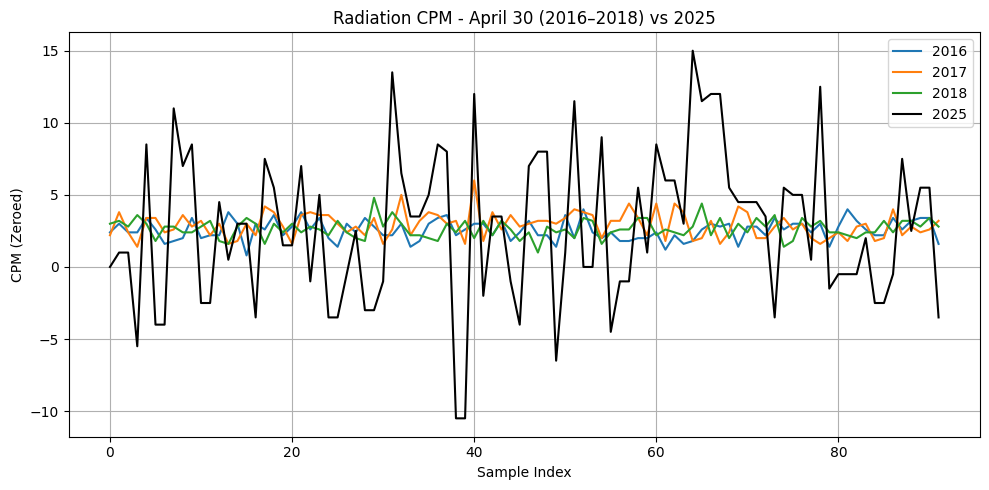

In [20]:
url = 'https://dl.dropboxusercontent.com/s/tc6s7f6xl05kwzh/etch_roof.csv?dl=1'
etch_data = pd.read_csv(url)

etch_data['deviceTime_utc'] = pd.to_datetime(etch_data['deviceTime_utc'])

full_day_data = {}
for year in [2016, 2017, 2018]:
    start_time = pd.Timestamp(f"{year}-04-30 00:00:00", tz="UTC")
    end_time = pd.Timestamp(f"{year}-04-30 23:59:59", tz="UTC")
    mask = (etch_data['deviceTime_utc'] >= start_time) & (etch_data['deviceTime_utc'] <= end_time)
    full_day_data[year] = etch_data[mask].copy()

aligned_data = {}
for year in [2016, 2017, 2018]:
    aligned_data[year] = full_day_data[year].head(92).copy()
    aligned_data[year]["Measurement"] = range(92)

for year in [2016, 2017, 2018]:
    aligned_data[year]["cpm"] = pd.to_numeric(aligned_data[year]["cpm"], errors="coerce").astype("float64")
    aligned_data[year] = aligned_data[year].dropna(subset=["cpm"])

data_etch_box_test = data_etch_box.tail(92).copy()
data_etch_box_test["Measurement"] = range(92)
data_etch_box_test["cpm"] = data_etch_box_test["counts"] - data_etch_box_test["counts"].iloc[0]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for year in [2016, 2017, 2018]:
    plt.plot(aligned_data[year]["Measurement"], aligned_data[year]["cpm"], label=f"{year}")
plt.plot(data_etch_box_test["Measurement"], data_etch_box_test["cpm"], label="2025", color="black")
plt.title("Radiation CPM - April 30 (2016–2018) vs 2025")
plt.xlabel("Sample Index")
plt.ylabel("CPM (Zeroed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

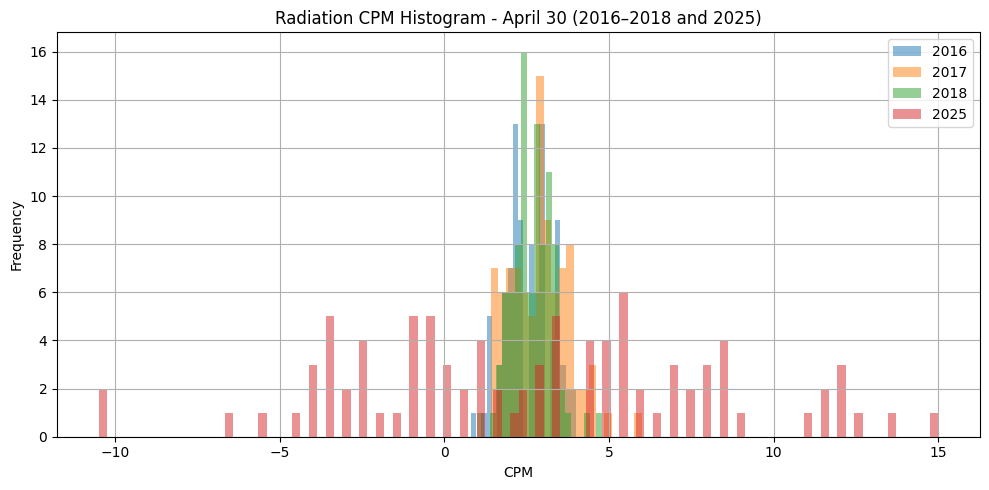

Mean CPM for 2016: 2.56
Mean CPM for 2017: 2.91
Mean CPM for 2018: 2.66
Mean CPM for 2025: 2.73


In [21]:
plt.figure(figsize=(10, 5))

for year in [2016, 2017, 2018]:
    plt.hist(aligned_data[year]["cpm"], bins=20, alpha=0.5, label=f"{year}")
plt.hist(data_etch_box_test["cpm"], bins=100, alpha=0.5, label="2025")
plt.title("Radiation CPM Histogram - April 30 (2016–2018 and 2025)")
plt.xlabel("CPM")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

for year in [2016, 2017, 2018]:
    mean_val = aligned_data[year]["cpm"].mean()
    print(f"Mean CPM for {year}: {mean_val:.2f}")

mean_2025 = data_etch_box_test["cpm"].mean()
print(f"Mean CPM for 2025: {mean_2025:.2f}")